In [17]:
# https://towardsdatascience.com/darts-swiss-knife-for-time-series-forecasting-in-python-f37bb74c126

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import plotly.express as px
import plotly.graph_objects as go

import pmdarima as pmd
from darts.models.forecasting import auto_arima, varima
from darts import TimeSeries

from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox

from statsmodels.tsa.seasonal import seasonal_decompose

MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default

In [18]:
## fit the chosen forecaster model and compute predictions

def eval_model(model, train, val):
    # fit the model and compute predictions
    res = model.fit(train)
    forecast = model.predict(len(val))

    # compute accuracy metrics and processing time
#     res_mape = mape(val, forecast)
    res_mae = mae(val, forecast)
    res_r2 = r2_score(val, forecast)
    res_rmse = rmse(val, forecast)
    res_rmsle = rmsle(val, forecast)
    res_accuracy = {"MAE":res_mae, "R squared":-res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle}

    results = [forecast, res_accuracy]
    return results

In [19]:
# check for seasonality, via ACF
def prep_seasonality(series, ALPHA):
    for m in range(2, 168+1):
        is_seasonal, mseas = check_seasonality(series,m=m, alpha=ALPHA, max_lag=168)
        if is_seasonal:
            break

    print("seasonal? " + str(is_seasonal))
    if is_seasonal:
        print('There is seasonality of order {}.'.format(mseas))

    split_at = TRAIN
    train, val = series.split_before(split_at)

    plt.figure(101, figsize=(12, 5))
    train.plot(label='training')
    val.plot(label='validation')
    plt.legend();
    
    return is_seasonal, mseas, train, val

In [20]:
def prep_ARIMA(series, ALPHA, mseas, is_seasonal):
    # prepare ARIMA forecaster
    y = np.asarray(series.pd_series())
    # get order of first differencing: the higher of KPSS and ADF test results
    n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2)
    n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2)
    n_diff = max(n_adf, n_kpss)

    # get order of seasonal differencing: the higher of OCSB and CH test results
    n_ocsb = pmd.arima.OCSBTest(m=max(168,mseas)).estimate_seasonal_differencing_term(y)
    n_ch = pmd.arima.CHTest(m=max(168,mseas)).estimate_seasonal_differencing_term(y)
    ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

    # set up the ARIMA forecaster
    model = auto_arima.AutoARIMA(
        start_p=2, d=n_diff, start_q=2,
        max_p=4, max_d=n_diff, max_q=4,
        start_P=2, D=ns_diff, start_Q=2, m=max(4,mseas), seasonal=is_seasonal,
        max_P=3, max_D=1, max_Q=3,
        max_order=5,                       # p+q+p+Q <= max_order
        stationary=False, 
        information_criterion="bic", alpha=ALPHA, 
        test="kpss", seasonal_test="ocsb",
        stepwise=True, 
        suppress_warnings=True, error_action="trace", trace=True, with_intercept="auto")
    
    return model

In [21]:
def plot(series, predictions, title):
    df = series.pd_dataframe()
    p = series.pd_series()
    p.update(predictions[0].pd_series())
    df[1] = p
    
    df = df.rename(columns={0:"Actual", 1:"Predicted"})
    fig = px.line(df, title=title)
    return fig

seasonal? False


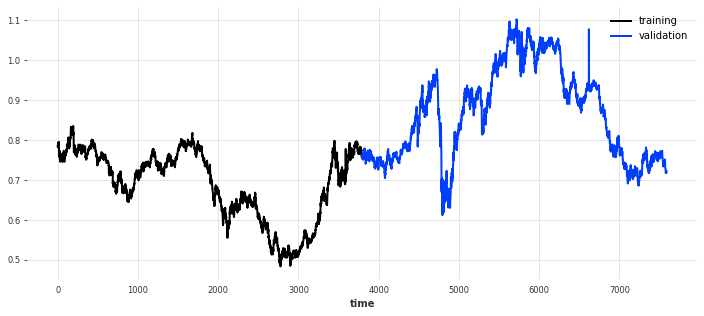

In [22]:
df = pd.read_csv("../exchange_rate/exchange_rate.txt", header=None)
# df = pd.read_csv("../electricity/electricity.txt", header=None)
# df = pd.read_csv("../solar-energy/solar_AL.txt", header=None)

series = TimeSeries.from_series(df[0])
TRAIN = int(len(df)*.5)

is_seasonal, mseas, train, val = prep_seasonality(series, ALPHA)

model = prep_ARIMA(series, ALPHA, mseas, is_seasonal)

In [23]:
predictions = eval_model(model, train, val)

/home/jacky/Storage/miniconda3/envs/snek/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (4) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=-30023.939, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=-30024.690, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=-30043.987, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=-30044.546, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=-30032.919, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=-30036.727, Time=1.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=-30036.566, Time=1.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=-30028.106, Time=2.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=-30052.773, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=-30044.955, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=-30044.795, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=-30052.214, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=-30036.333, Time=0.69 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.519 seco

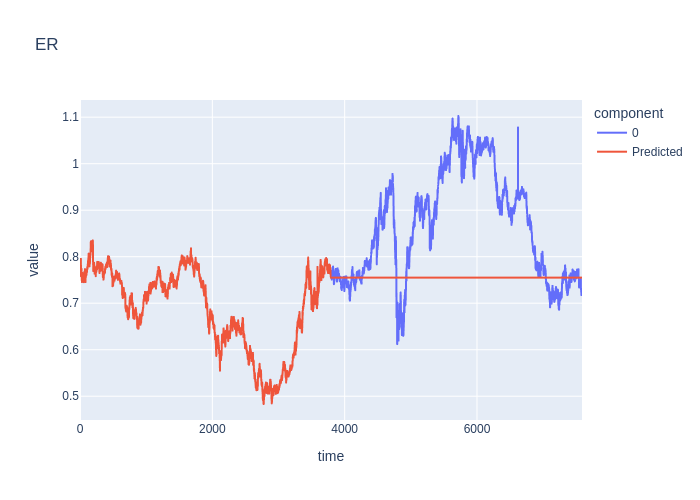

In [25]:
fig = plot(series, predictions, "ER")
fig.show("png")

# Traffic

In [27]:
# df = pd.read_csv("../exchange_rate/exchange_rate.txt", header=None)
# df = pd.read_csv("../electricity/electricity.txt", header=None)
# df = pd.read_csv("../solar-energy/solar_AL.txt", header=None)
df = pd.read_csv("../traffic/traffic.txt", header=None)
print(df.shape)

(17544, 862)


seasonal? True
There is seasonality of order 24.
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(2,1,2)[24] intercept   : BIC=-446.663, Time=10.40 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : BIC=-448.251, Time=0.23 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : BIC=-470.337, Time=1.20 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : BIC=-469.855, Time=1.11 sec
 ARIMA(0,0,0)(0,1,0)[24]             : BIC=-453.210, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : BIC=-474.747, Time=0.25 sec
 ARIMA(1,0,0)(0,1,1)[24] intercept   : BIC=-470.308, Time=1.82 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : BIC=inf, Time=2.80 sec
 ARIMA(2,0,0)(0,1,0)[24] intercept   : BIC=-471.009, Time=0.43 sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : BIC=-471.252, Time=0.56 sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : BIC=-474.501, Time=0.40 sec
 ARIMA(2,0,1)(0,1,0)[24] intercept   : BIC=-466.399, Time=0.47 sec
 ARIMA(1,0,0)(0,1,0)[24]             : BIC=-479.713, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[24]             : BI

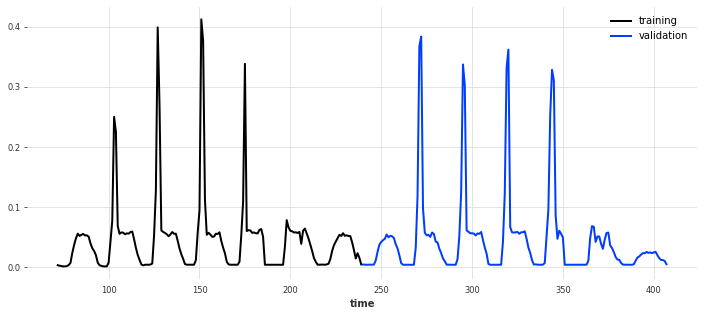

In [28]:
series = TimeSeries.from_series(df[0])

initial_offset=72
n = 2
series = series[initial_offset:initial_offset + n * 168]

TRAIN = initial_offset + (n - 1) * 168

is_seasonal, mseas, train, val = prep_seasonality(series, ALPHA)

model = prep_ARIMA(series, ALPHA, mseas, is_seasonal)

predictions = eval_model(model, train, val)

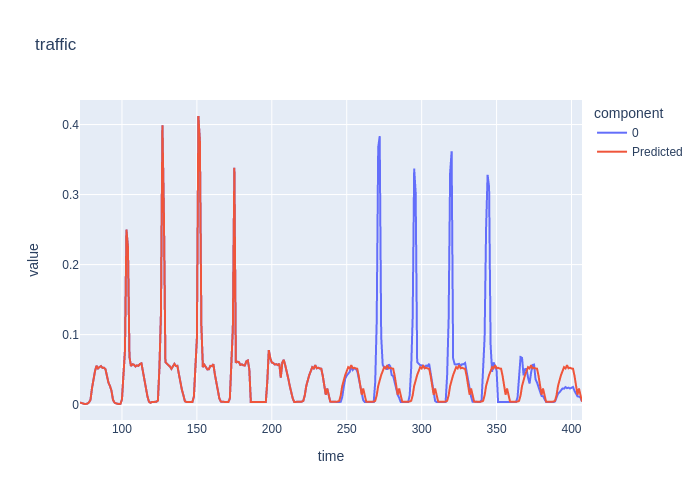

In [29]:
fig = plot(series, predictions, "traffic")
fig.show("png")